# Constructing EOS and solving TOV equations beyond General Relativity

This example notebook shows how to construct the equation of state with the metamodel and speed-of-sound extension scheme parametrization used in the paper, as well as solve the TOV equations beyond GR. 

In [1]:
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)

import jax.numpy as jnp
import jax
from jesterTOV.eos.metamodel.metamodel_CSE import MetaModel_with_CSE_EOS_model
from jesterTOV.eos.families import construct_family, construct_family_nonGR, construct_family_ST, construct_family_ST_Greci, construct_family_ST_sol, construct_family_eibi
import jesterTOV.utils as utils
import time

W0119 15:47:35.806426  441464 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0119 15:47:35.808866  441379 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


# Equation of state

In [2]:
nsat = 0.16 # nuclear saturation density in fm^-3

# Define the EOS object, here we focus on Metamodel with CSE
eos = MetaModel_with_CSE_EOS_model(nmax_nsat=6.0)

# Define the nuclear empirical parameters (NEPs) -- all in MeV
NEP_dict = {"E_sat": -16.0, # saturation parameters
            "K_sat": 200.0,
            "Q_sat": 0.0,
            "Z_sat": 0.0,
            "E_sym": 32.0, # symmetry parameters
            "L_sym": 70.0,
            "K_sym": -100.0,
            "Q_sym": 0.0,
            "Z_sym": 0.0,
            }

# Define the breakdown density -- this is usually between 1-2 nsat
nbreak = 1.5 * nsat
NEP_dict["nbreak"] = nbreak

# Then we extend with some CSE grid points
ngrids = jnp.array([2.0, 3.0, 4.0, 5.0]) * nsat
cs2grids = jnp.array([0.5, 0.4, 0.3, 0.2]) # speed of sound squared at the grid points

# Now create the EOS -- returns a tuple with most useful EOS quantities
ns, ps, hs, es, dloge_dlogps, mu, cs2 = eos.construct_eos(NEP_dict, ngrids, cs2grids)

# Make a plot
plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

# For the plot, let's make some conversions to more common units
ns_plots = ns / utils.fm_inv3_to_geometric / 0.16
es_plots = es / utils.MeV_fm_inv3_to_geometric
ps_plots = ps / utils.MeV_fm_inv3_to_geometric

# p(n)
plt.subplot(221)
plt.plot(ns_plots, ps_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")

# e(n)
plt.subplot(222)
plt.plot(ns_plots, es_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$e$ [MeV/fm$^3$]")

# cs2(n)
plt.subplot(223)
plt.plot(ns_plots, cs2)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$c_s^2$")
plt.axvline(0.5, color = "red", label = "Crust-core transition")
plt.axvline(nbreak / nsat, color = "black", label = r"$n_{\rm{break}}$")
plt.legend()

# p(e)
plt.subplot(224)
plt.plot(es_plots, ps_plots)
plt.xlabel(r"$e$ [MeV/fm$^3$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.tight_layout()
# plt.show() # uncomment to see the EOS
plt.close()

# 1. Neutron stars in Standard Scalar-Tensor Theory

#### 1. a. Solving the TOV equations to construct an M(R) curve and calculate their tidal deformabilities based on Ref. Stephanie M. Brown 2023 ApJ 958 125


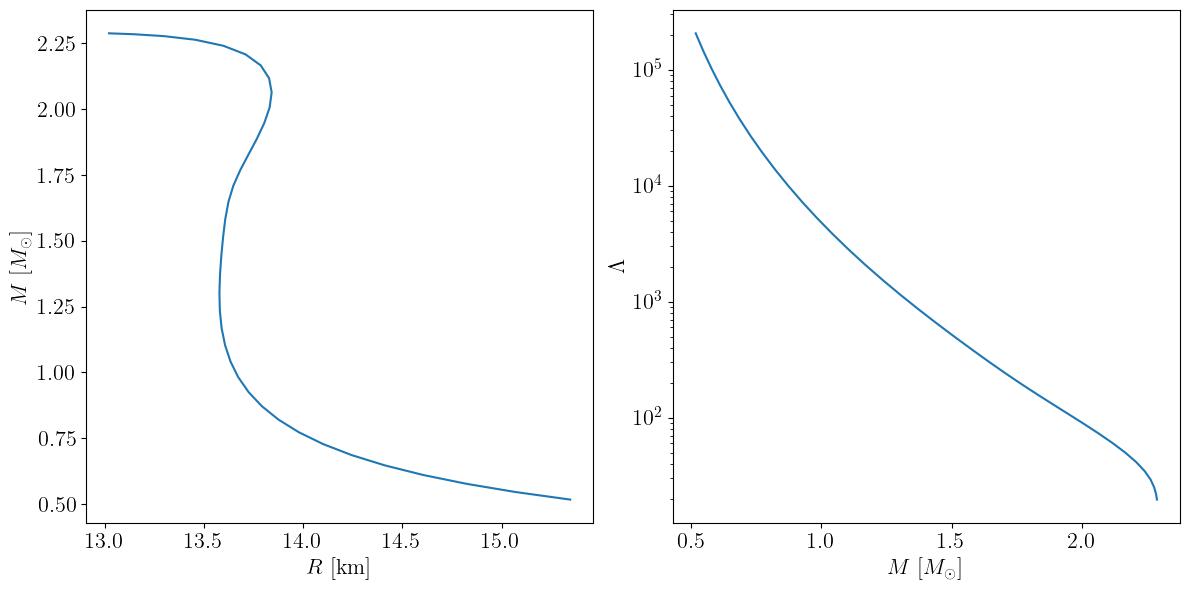

In [3]:
# Solve TOV equations:
beta_ST = -4.5
#initial guesses
phi_c = 1
phi_inf_tgt = 1e-3
#Enter through EoS
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2, beta_ST, phi_c, phi_inf_tgt)
logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple, ndat = 50, min_nsat = 1.0)
# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Limit masses to be above certain mass to make plot prettier
m_min = 0.5
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.plot(masses, Lambdas)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

Below is to solve the TOV equations for a single mass in debug mode, to recover full details on the constructed solution.
Note that in this mode, central $\nu$ has to be defined.

In [4]:
# Solve TOV equations:
beta_ST = -4.5
phi_c = -0.1
nu_c = -1.2
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2, beta_ST, phi_c, nu_c)
logpc, masses, radii, Lambdas, sol_iter, sol_ext = construct_family_ST_sol(eos_tuple, ndat = 1, min_nsat = 3.0)

# Limit masses to be above certain mass to make plot prettier
m_min = 0.5
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# Check out first batch
r_vals_float   = sol_ext.ts[0]
M_vals_float   = sol_ext.ys[0][0]
nu_vals_float  = sol_ext.ys[1][0]
phi_vals_float = sol_ext.ys[2][0]
psi_vals_float = sol_ext.ys[3][0]

Iteration 0: ν∞=0.07841465163765411, φ∞=-3.458794687225946e-05,νc=-1.2627317213101232, φc=-0.0999723296425022, M=2.1067100286867997
Iteration 1: ν∞=0.01585122846106577, φ∞=-1.5290476435984683e-05,νc=-1.2754127040789758, φc=-0.09996009726135341, M=2.1070647712758563
Iteration 2: ν∞=0.003193009172783405, φ∞=-1.2954193578559403e-05,νc=-1.2779671114172024, φc=-0.09994973390649056, M=2.1070954423974975
Iteration 3: ν∞=0.0006457177315805651, φ∞=-1.254538914411874e-05,νc=-1.2784836856024668, φc=-0.09993969759517526, M=2.107091049818068
Iteration 4: ν∞=0.000137228757790949, φ∞=-1.2089179228929968e-05,νc=-1.2785934686086995, φc=-0.09993002625179212, M=2.107089094428729
Iteration 5: ν∞=3.548323162693204e-05, φ∞=-1.1636550852025786e-05,νc=-1.278621855194001, φc=-0.0999207170111105, M=2.107087690346318
Iteration 6: ν∞=1.488165765021034e-05, φ∞=-1.1198376113563251e-05,νc=-1.2786337605201212, φc=-0.09991175831021964, M=2.1070864345037448
Iteration 7: ν∞=1.0477337587285222e-05, φ∞=-1.0776295407171293

From the output of debug mode, after iteration complete, we can plot the exterior solution:

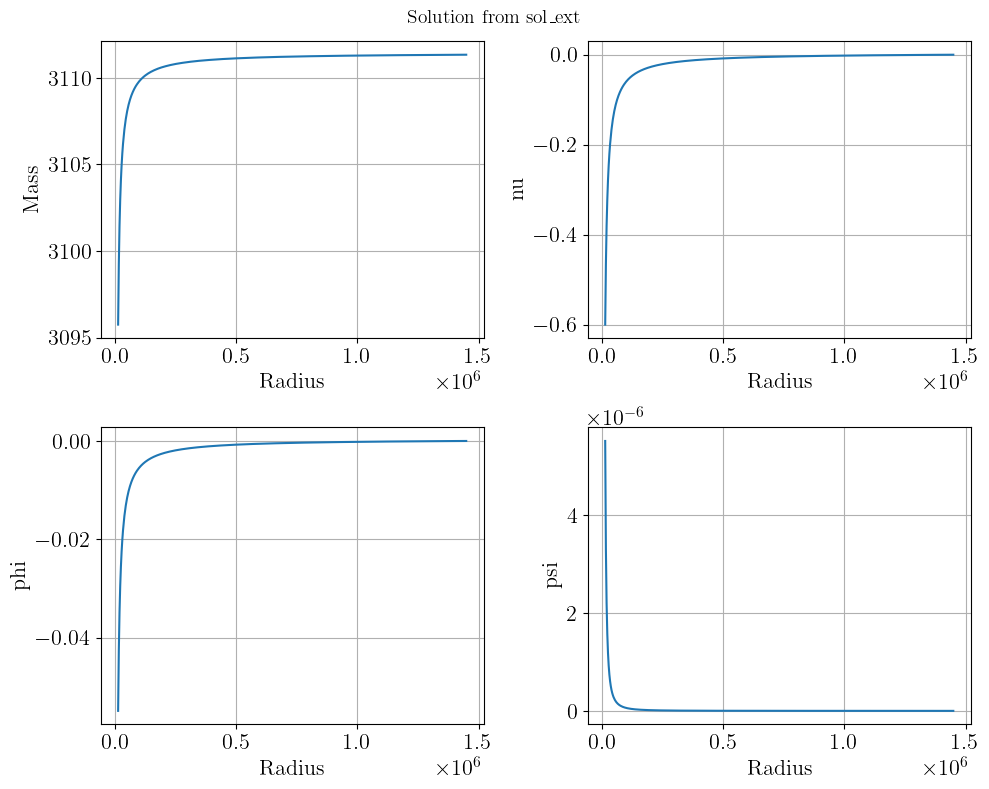

In [5]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Solution from sol_ext", fontsize=14)

# M vs r
axs[0, 0].plot(r_vals_float, M_vals_float)
axs[0, 0].set_xlabel("Radius")
axs[0, 0].set_ylabel("Mass")
axs[0, 0].grid(True)

# nu vs r
axs[0, 1].plot(r_vals_float, nu_vals_float)
axs[0, 1].set_xlabel("Radius")
axs[0, 1].set_ylabel("nu")
axs[0, 1].grid(True)

# phi vs r
axs[1, 0].plot(r_vals_float, phi_vals_float)
axs[1, 0].set_xlabel("Radius")
axs[1, 0].set_ylabel("phi")
axs[1, 0].grid(True)

# psi vs r
axs[1, 1].plot(r_vals_float, psi_vals_float)
axs[1, 1].set_xlabel("Radius")
axs[1, 1].set_ylabel("psi")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()



And combine interior and exterior to see the full profile

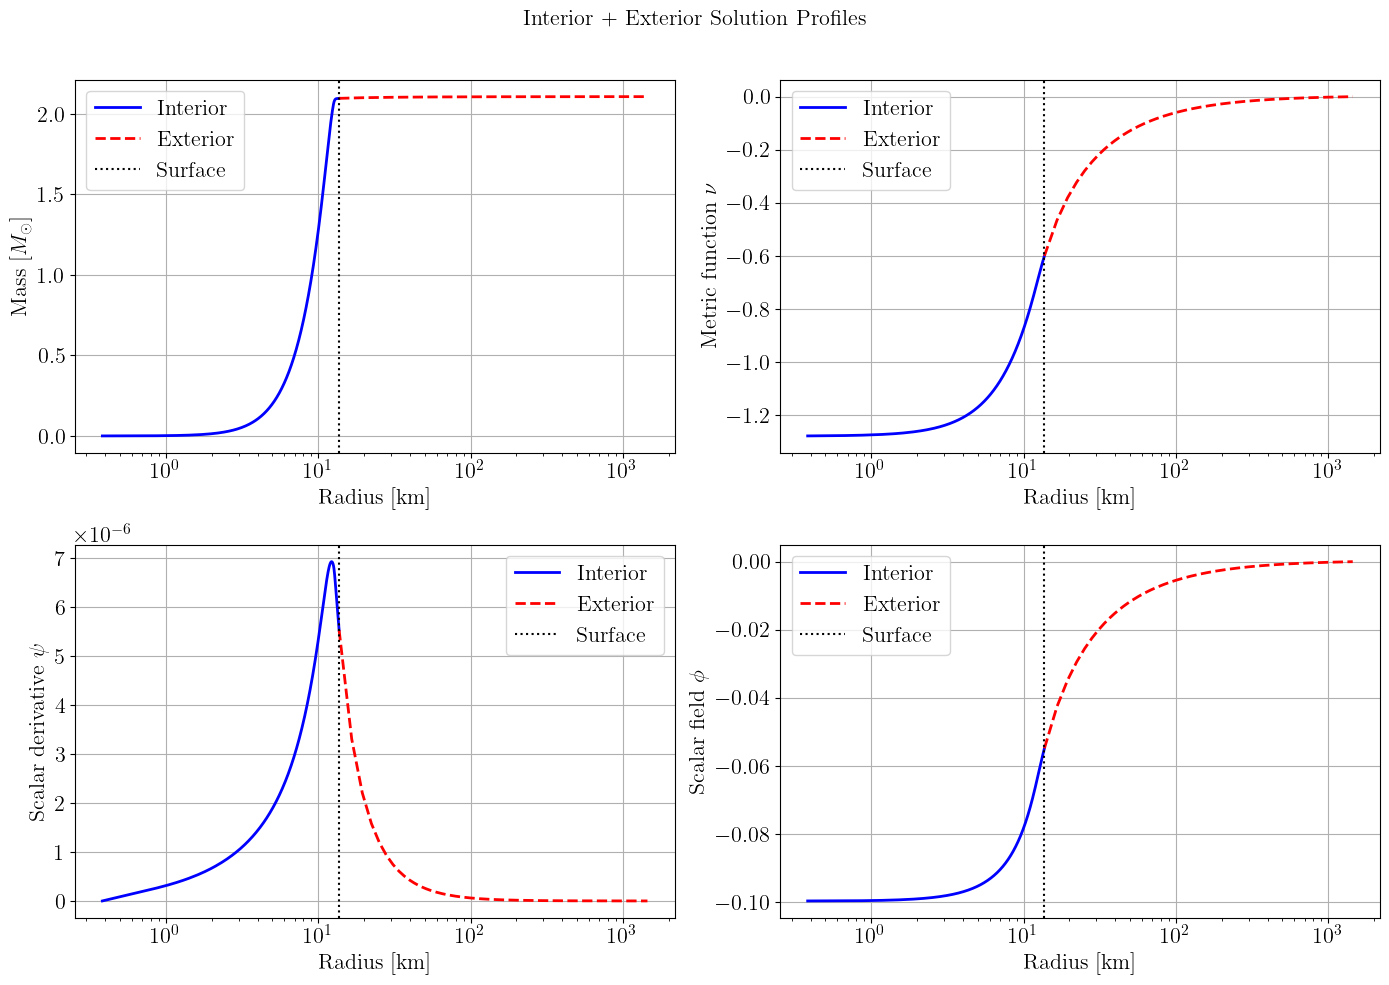

In [6]:
# Extract interior and exterior profiles
#y0 = (r0, m0, nu0_final, psi0, phi0_final)
r_int_m = sol_iter.ys[0][0]
M_int = sol_iter.ys[1][0]
nu_int = sol_iter.ys[2][0]
psi_int = sol_iter.ys[3][0]
phi_int = sol_iter.ys[4][0]
#y_surf = (M_s, nu_s, phi_s, psi_s)
r_ext_m = sol_ext.ts[0]
M_ext = sol_ext.ys[0][0]
nu_ext = sol_ext.ys[1][0]
phi_ext = sol_ext.ys[2][0]
psi_ext = sol_ext.ys[3][0]

# Convert to kilometers and solar masses
r_int = r_int_m / 1000
r_ext = r_ext_m / 1000
M_int_solar = M_int / utils.solar_mass_in_meter
M_ext_solar = M_ext / utils.solar_mass_in_meter

# Create composite plots with logarithmic x-axis
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Interior + Exterior Solution Profiles", fontsize=16)

# Mass Profile
axs[0, 0].semilogx(r_int, M_int_solar, 'b-', linewidth=2, label='Interior')
axs[0, 0].semilogx(r_ext, M_ext_solar, 'r--', linewidth=2, label='Exterior')
axs[0, 0].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[0, 0].set_xlabel("Radius [km]")
axs[0, 0].set_ylabel(r"Mass [$M_\odot$]")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Metric Function ν
axs[0, 1].semilogx(r_int, nu_int, 'b-', linewidth=2, label='Interior')
axs[0, 1].semilogx(r_ext, nu_ext, 'r--', linewidth=2, label='Exterior')
axs[0, 1].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[0, 1].set_xlabel("Radius [km]")
axs[0, 1].set_ylabel(r"Metric function $\nu$")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Scalar Derivative ψ
axs[1, 0].semilogx(r_int, psi_int, 'b-', linewidth=2, label='Interior')
axs[1, 0].semilogx(r_ext, psi_ext, 'r--', linewidth=2, label='Exterior')
axs[1, 0].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[1, 0].set_xlabel("Radius [km]")
axs[1, 0].set_ylabel(r"Scalar derivative $\psi$")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Scalar Field φ
axs[1, 1].semilogx(r_int, phi_int, 'b-', linewidth=2, label='Interior')
axs[1, 1].semilogx(r_ext, phi_ext, 'r--', linewidth=2, label='Exterior')
axs[1, 1].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[1, 1].set_xlabel("Radius [km]")
axs[1, 1].set_ylabel(r"Scalar field $\phi$")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Exploration of scalar-tensor effects

Below, we show the solutions for a sweep of the beta parameter space: mass, radius, and tidal deformability.
Done using vmap to parallelize values of $\beta_{ST}$.

vmap running...
🔥 All calcs of 7 kappa values finished in 44.2957 seconds.


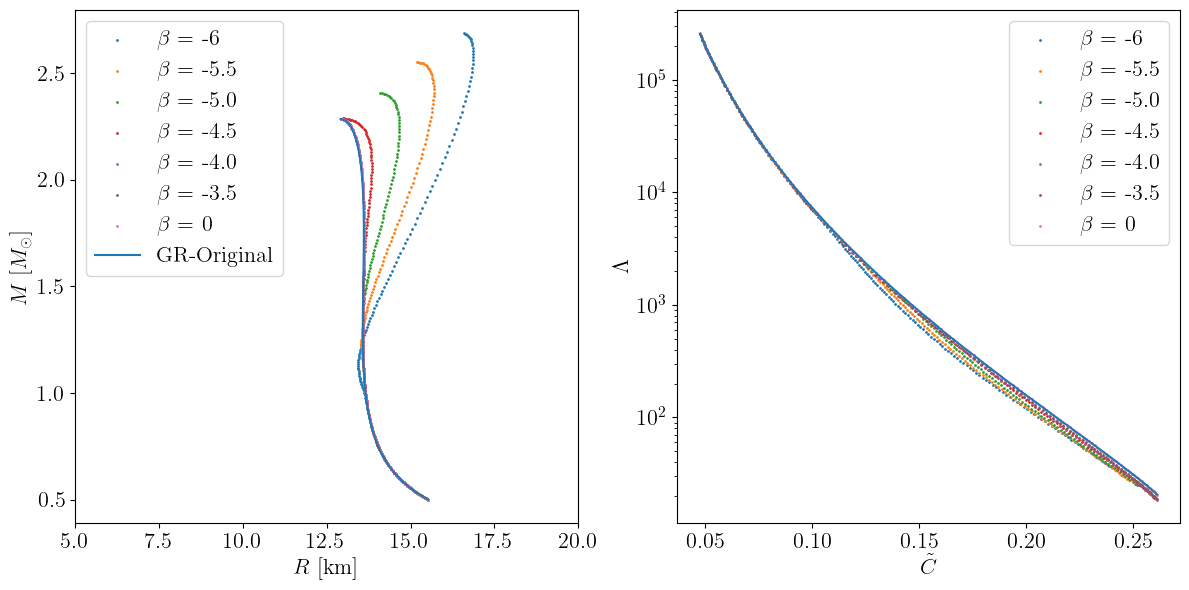

In [7]:
# Solve TOV equations for multiple beta values:
beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# initial guess
phi_c = 1
phi_inf_tgt = 1e-3

# Use vmap
print("vmap running...")
def calculate_ns_properties(beta_ST):
    """
    vmap wrapper for solver function
    """
    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, cs2, beta_ST, phi_c, phi_inf_tgt)
    logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple_ST, ndat=200, min_nsat=0.1)
    return logpc, masses, radii, Lambdas
    
beta_array = jnp.array(beta_values)
calculate_ns_properties_vmapped = jax.vmap(calculate_ns_properties)

start_time = time.time()

v_logpc, v_masses, v_radii, v_Lambdas = calculate_ns_properties_vmapped(beta_array)

v_masses.block_until_ready()

end_time = time.time()
duration = end_time - start_time

print(f"🔥 All calcs of {len(beta_values)} kappa values finished in {duration:.4f} seconds.")

# create results dict
results = {}
r_max = 50 #in km
for i, beta_ST in enumerate(beta_values):
    radii = v_radii[i]
    masses = v_masses[i]
    mask = (radii < r_max) & (radii > 5) & (masses > 0.5)

    results[beta_ST] = {
        "masses": v_masses[i][mask],
        "radii": v_radii[i][mask],
        "Lambdas": v_Lambdas[i][mask],
        "pcs" : jnp.exp(v_logpc[i][mask]),
    }

plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)

#Calculate GR case
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2)
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat=300, min_nsat=0.5)
# Limit masses to be above certain mass to make plot prettier
mask = (radii < r_max) & (radii > 5) & (masses > 0.5)
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]
pc = jnp.exp(logpc[mask])

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original')

plt.xlabel(r"$R$ [km]")
plt.xlim(5,20)
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, jnp.abs(data["Lambdas"]), label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), Lambdas)
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()



Difference of tidal deformability calculated between ST and GR.

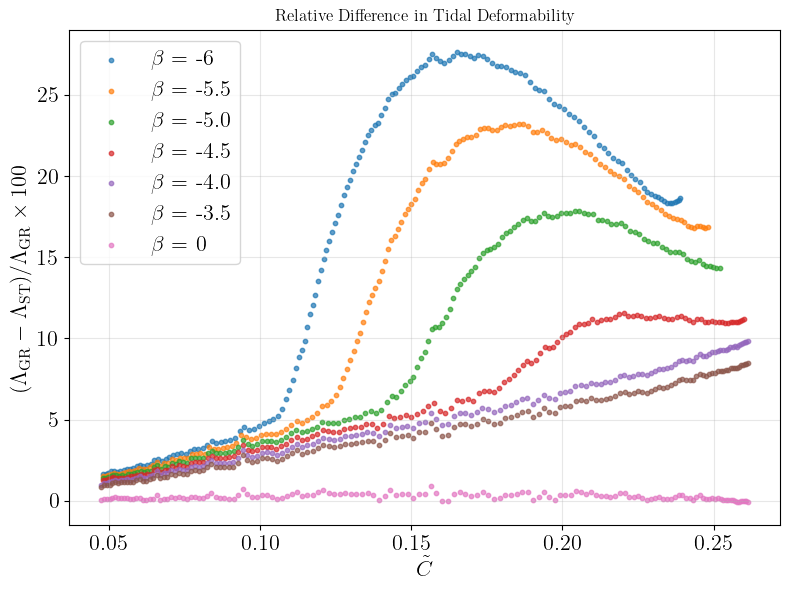

In [8]:
# New plot: Relative difference in tidal deformability
plt.figure(figsize=(8, 6))

# Compute GR compactness and Lambda for interpolation
C_GR = masses * utils.solar_mass_in_meter / (radii * 1e3)

# Create interpolation function for GR Lambda vs C
from scipy.interpolate import interp1d
Lambda_GR_interp = interp1d(C_GR, Lambdas, bounds_error=False, fill_value="extrapolate")

for beta_ST, data in results.items():
    # Compute compactness for ST case
    C_ST = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    
    # Get GR Lambda at the same compactness values
    Lambda_GR_at_C = Lambda_GR_interp(C_ST)
    
    # relative difference: (Lambda_GR - Lambda_ST) / Lambda_GR
    rel_diff = (Lambda_GR_at_C - data["Lambdas"]) / Lambda_GR_at_C *100
    
    plt.scatter(C_ST, rel_diff, label=rf'$\beta$ = {beta_ST}', s=10, alpha=0.7)

plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$(\Lambda_{\mathrm{GR}} - \Lambda_{\mathrm{ST}}) / \Lambda_{\mathrm{GR}} \times 100$")
plt.title("Relative Difference in Tidal Deformability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### 1. b. Solving the TOV equations to construct an M(R) curve and calculate their tidal deformabilities based on Gastón Creci, Tanja Hinderer, Jan Steinhoff Phys.Rev.D 108 (2023) 12, 124073
This approach has the equivalent TOV with Brown (2023) hence the same M(R) curve, but different tidal deformabilities.

vmap running...
🔥 All calcs of 7 kappa values finished in 45.5664 seconds.


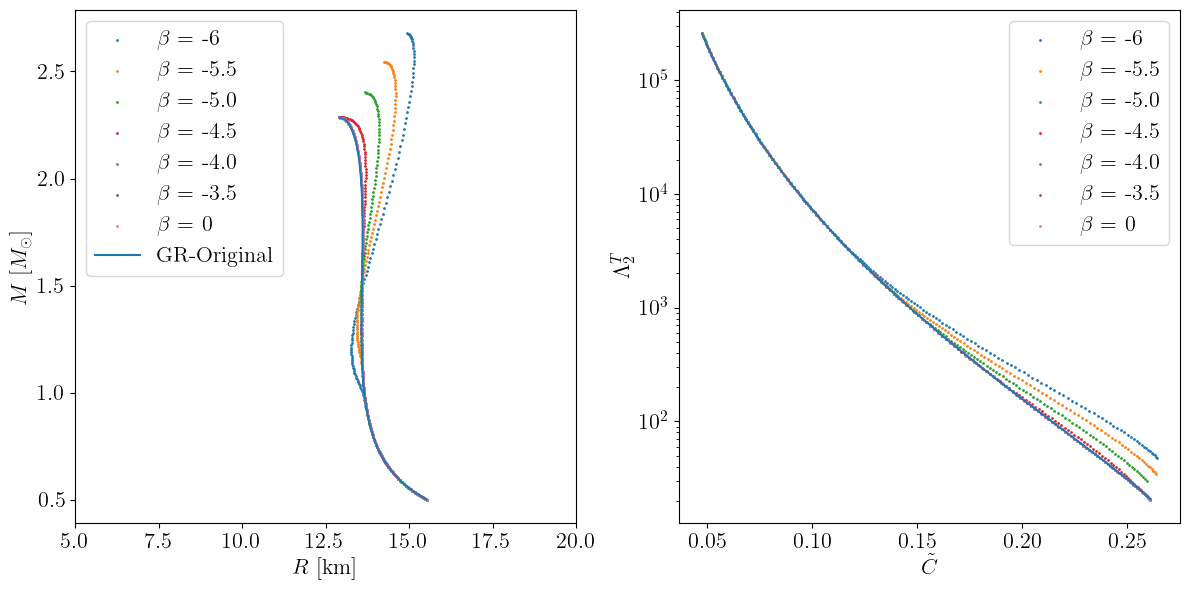

In [9]:
# Solve TOV equations for multiple beta values:
beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# initial guess
phi_c = 1
phi_inf_tgt = 1e-3

# Use vmap
print("vmap running...")
def calculate_ns_properties(beta_ST):
    """
    vmap wrapper for solver function
    """
    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, cs2, beta_ST, phi_c, phi_inf_tgt)
    logpc, masses, radii, LambdasT, LambdasS, LambdasST1, LambdasST2 = construct_family_ST_Greci(eos_tuple_ST, ndat=200, min_nsat=0.1)
    return logpc, masses, radii, LambdasT, LambdasS, LambdasST1, LambdasST2
    
beta_array = jnp.array(beta_values)
calculate_ns_properties_vmapped = jax.vmap(calculate_ns_properties)

start_time = time.time()

v_logpc, v_masses, v_radii, v_LambdasT, v_LambdasS, v_LambdasST1, v_LambdasST2 = calculate_ns_properties_vmapped(beta_array)

v_masses.block_until_ready()

end_time = time.time()
duration = end_time - start_time

print(f"🔥 All calcs of {len(beta_values)} kappa values finished in {duration:.4f} seconds.")

# create results dict
results = {}
r_max = 50 #in km
for i, beta_ST in enumerate(beta_values):
    radii = v_radii[i]
    masses = v_masses[i]
    mask = (radii < r_max) & (radii > 5) & (masses > 0.5)

    results[beta_ST] = {
        "masses": v_masses[i][mask],
        "radii": v_radii[i][mask],
        "LambdasT": v_LambdasT[i][mask],
        "LambdasS": v_LambdasS[i][mask],
        "LambdasST1": v_LambdasST1[i][mask],
        "LambdasST2": v_LambdasST2[i][mask],
        "pcs" : jnp.exp(v_logpc[i][mask]),
    }

plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)

# Calculate GR case -----------------------------------------
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2)
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat=300, min_nsat=0.5)
# Limit masses to be above certain mass to make plot prettier
mask = (radii < r_max) & (radii > 5) & (masses > 0.5)
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]
pc = jnp.exp(logpc[mask])
#------------------------------------------------------------
# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original')

plt.xlabel(r"$R$ [km]")
plt.xlim(5,20)
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, jnp.abs(data["LambdasT"]), label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), Lambdas)
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda_2^T$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()



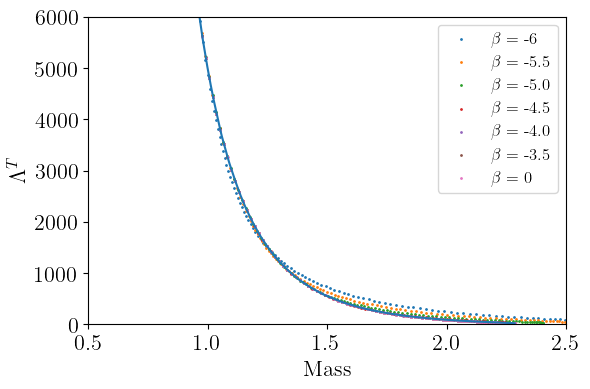

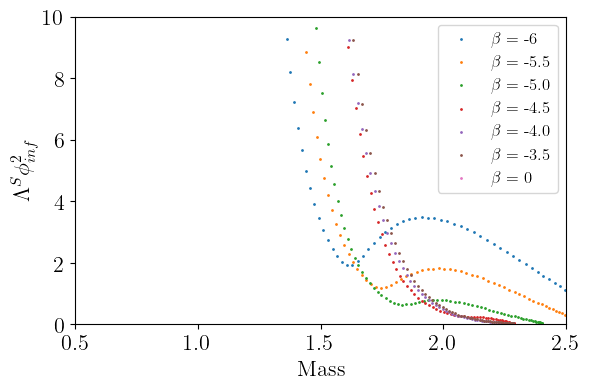

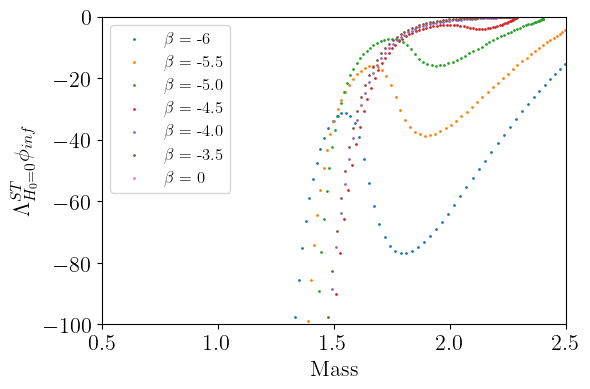

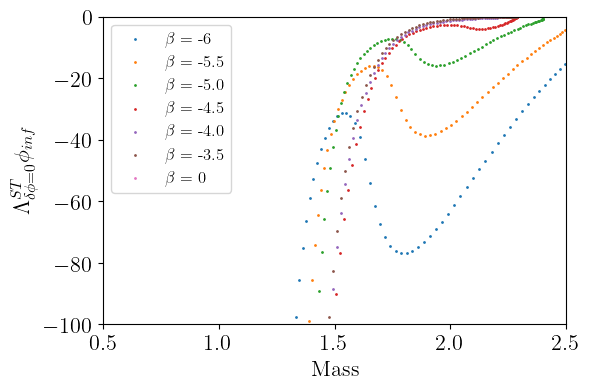

In [10]:
plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasT"]
    plt.scatter(data["masses"],lam, label=rf'$\beta$ = {beta_ST}',s=1)
plt.plot(masses, Lambdas) 
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^T$")
plt.ylim(0,6000)
plt.xlim(0.5,2.5)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasS"]
    plt.scatter(data["masses"],lam*phi_inf_tgt**2, label=rf'$\beta$ = {beta_ST}',s=1)
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^S \phi_{inf}^2$")
plt.ylim(0,10)
plt.xlim(0.5,2.5)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasST1"]
    plt.scatter(data["masses"],lam*phi_inf_tgt, label=rf'$\beta$ = {beta_ST}',s=1)
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^{ST}_{H_0 = 0} \phi_{inf}$")
plt.ylim(-100,0)
plt.xlim(0.5,2.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasST2"]
    plt.scatter(data["masses"],lam*phi_inf_tgt, label=rf'$\beta$ = {beta_ST}',s=1)
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^{ST}_{\delta \phi = 0} \phi_{inf}$")
plt.ylim(-100,0)
plt.xlim(0.5,2.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

# 2. Neutron stars in Eddington-inspired Born Infeld

Solving the TOV equations to construct an M(R) curve and calculate their tidal deformabilities based on Ref. I. Prasetyo et al Phys. Rev. D 104, 084029
Not all combinations of $\kappa$ - EoS have solution. No solution automatically returns nan.  

vmap running...
🔥 All calcs of 11 kappa values finished in 14.2716 seconds.
All kappa values done !!


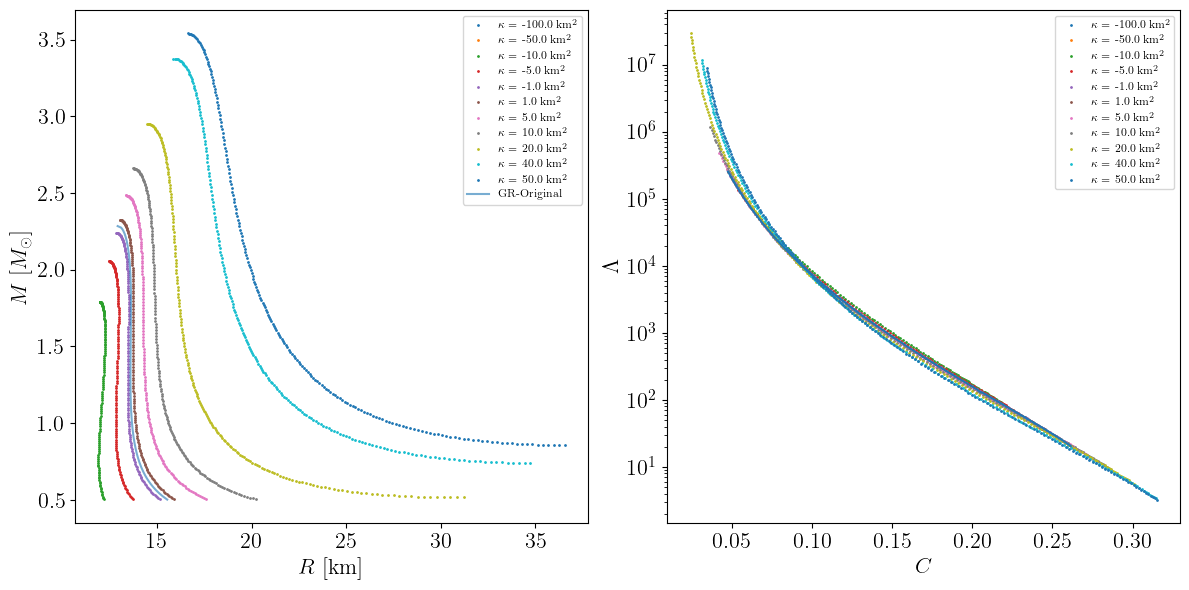

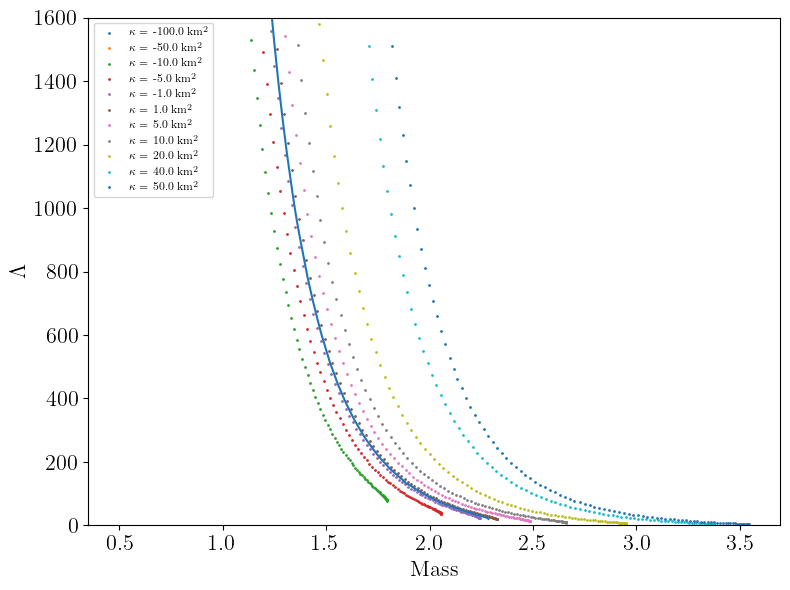

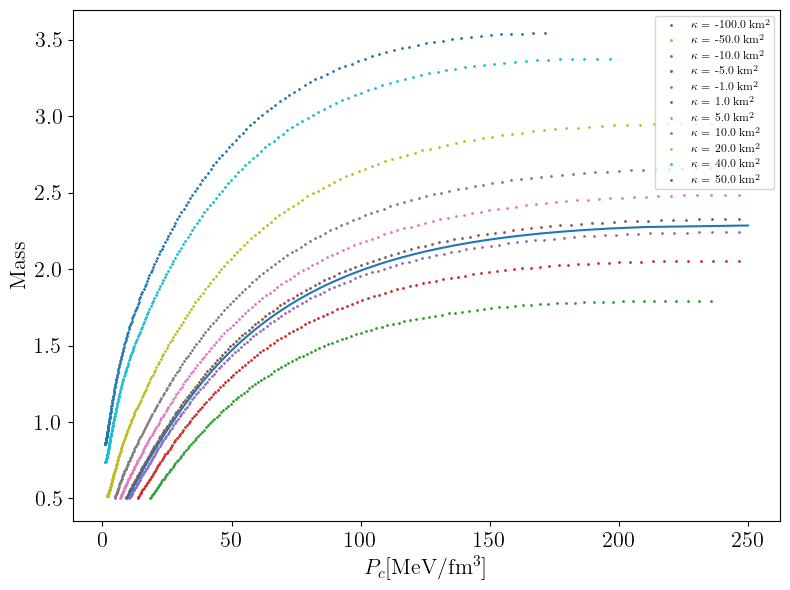

In [11]:
# Solve TOV equations:
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2)

# Solve TOV equations for multiple kappa values:
kappa_values = [-1e8, -5e7, -1e7, -5e6, -1e6, 1e6, 5e6, 1e7, 2e7, 4e7, 5e7]
Lambda_cosmo = 1.4657e-52 #in 1/m^2 from Daniel Scolnic et al 2025 ApJL 979 L9


print("vmap running...")
def calculate_ns_properties(kappa_eibi):
    """
    vmap wrapper function
    """
    eos_tuple_eibi = (ns, ps, hs, es, dloge_dlogps, cs2, kappa_eibi, Lambda_cosmo)
    logpc, masses, radii, Lambdas = construct_family_eibi(eos_tuple_eibi, ndat=200, min_nsat=0.1)

    r_max = 50
    return logpc, masses, radii, Lambdas


kappa_array = jnp.array(kappa_values)
calculate_ns_properties_vmapped = jax.vmap(calculate_ns_properties)

start_time = time.time()

v_logpc, v_masses, v_radii, v_Lambdas = calculate_ns_properties_vmapped(kappa_array)

v_masses.block_until_ready()

end_time = time.time()
duration = end_time - start_time


print(f"🔥 All calcs of {len(kappa_values)} kappa values finished in {duration:.4f} seconds.")

results = {}
r_max = 50
for i, kappa_eibi in enumerate(kappa_values):
    radii = v_radii[i]
    masses = v_masses[i]
    mask = (radii < r_max) & (radii > 5) & (masses > 0.5)

    results[kappa_eibi] = {
        "masses": v_masses[i][mask],
        "radii": v_radii[i][mask],
        "Lambdas": v_Lambdas[i][mask],
        "pcs" : jnp.exp(v_logpc[i][mask]),
    }
print("All kappa values done !!")


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for kappa_eibi, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\kappa$ = {kappa_eibi/1e6} km$^2$',s=1)

eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2)
# GR !!!!
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat=200, min_nsat=1)
# Limit masses to be above certain mass to make plot prettier
r_max = 50
mask = (radii < r_max) & (radii > 5) & (masses > 0.5)
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]
pc = jnp.exp(logpc[mask])

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original', alpha=0.6)

plt.xlabel(r"$R$ [km]")
# plt.xlim(5,20)
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend(loc='upper right', fontsize=8)
# Λ(C) plot
plt.subplot(122)
for kappa_eibi, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, jnp.abs(data["Lambdas"]), label=rf'$\kappa$ = {kappa_eibi/1e6} km$^2$',s=1)
plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), Lambdas) #temporary hide it
plt.xlabel(r"$C$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
for kappa_eibi, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    M = data["masses"] 
    plt.scatter(M, jnp.abs(data["Lambdas"]), label=rf'$\kappa$ = {kappa_eibi/1e6} km$^2$',s=1)
plt.plot(masses, Lambdas) #temporary hide it
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda$")
plt.yscale("linear")
plt.legend(loc='upper left', fontsize=8)
plt.ylim(0,1600)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
for kappa_eibi, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    pcs = data["pcs"] 
    plt.scatter(pcs*utils.geometric_to_MeV_fm_inv3, data["masses"], label=rf'$\kappa$ = {kappa_eibi/1e6} km$^2$',s=1)
plt.plot(pc*utils.geometric_to_MeV_fm_inv3, masses)
plt.ylabel(r"Mass")
plt.xlabel(r"$P_c$[MeV/fm$^3$]")
plt.yscale("linear")
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()
plt.close()
